In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
import scipy.sparse.linalg
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import conv2d
import functools
from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from functools import partial
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [41]:
from crf.gaussian_matrix import *

In [4]:
from crf.utils import read_image, read_pfm, read_pgm
from crf.features import Vgg16features
from crf.crf_module import *
from crf.depth import *

In [25]:
img1 = read_image('imL.png')
img2 = read_image('imR.png')
gt_depth = read_pgm('truedisp.row3.col3.pgm')
# img1 = read_image('im0.png')[::3,::3]
# img2 = read_image('im1.png')[::3,::3]
#gt_depth = read_pfm('disp0.pfm')[::3,::3]
# img1 = read_image('im2.png')
# img2 = read_image('im6.png')
#gt_depth = read_pgm('disp2.pgm')
scale =4
device = torch.device('cuda')#torch.device('cuda')#torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
q = 0
# Get random projection of VGG16 features
VGG = Vgg16features()
VGG.to(device)
VGG.eval()
features = VGG.get_features(img1,k=q+1)
torch_features = torch.from_numpy(features[q]).to(device).detach()

In [7]:
print(img1.shape)
print(torch_features.shape)

(288, 384, 3)
torch.Size([288, 384, 64])


In [8]:
np.tile(np.mgrid[:3,:4],(5,1,1,1,1)).shape

(5, 1, 2, 3, 4)

In [20]:
d=5
class featureGuide(nn.Module):
    def __init__(self):
        super().__init__()
        self.projection = nn.Linear(64,d)
    def forward(self,x):
        projected_features = self.projection(torch_features).permute(2,0,1)
        #print(ij.shape,scaled_rgb.shape, projected_features.shape)
        return torch.cat([x,projected_features],dim=0)
    

class denseCRF2(nn.Module):
    def __init__(self,num_classes,n_iters=5,r0=20):
        super().__init__()
        self.device = torch.device('cuda')
        self.CRFlayer = CRFasRNN(charb(.05),n_iters,notrain_mu=False,gaussian=False,r=r0,gchannels=1)
        self.CRFlayer.to(self.device)
        self.CRFguide = featureGuide().to(self.device)#nn.Sequential()
        self.labels = torch.arange(num_classes).float().to(self.device)
    def forward(self,E0,x,maximum=False):
        guide = self.CRFguide(x.to(self.device))
        filtered = self.CRFlayer(guide.to(self.device)[None,...],-E0.to(self.device)[None,...])
        if maximum: return torch.argmax(filtered.squeeze().permute(1,2,0).reshape(-1,len(self.labels)).cpu(),dim=1)
        else: return (filtered.squeeze().permute(1,2,0).reshape(-1,len(self.labels))@self.labels).cpu()
        


In [21]:
## Hyper parameters
ws = 9      # Disparity aggregation window size
sigma_c = .1#.15#.1#.1 # Filter stdev for color channels
sigma_p = .1#.08#.1 # Filter stdev for position channels
sigma_f = 3#3#10#3.46#10 # Filter stdev for feature channels
n_iters = 10 # Number of mean field message passing iterations
down_factor = 1

In [37]:
# Get the unary potentials from window sweep
disp_energy = disparity_badness(img1,img2,ws,criterion=AD)
disps = np.argmin(disp_energy,axis=-1)
L = disp_energy.shape[-1] # Number of possible disparities
downsampled_out = disp_energy[::down_factor,::down_factor]
h,w,_ = downsampled_out.shape
n = h*w

E_0 = torch.from_numpy(downsampled_out.reshape(-1,L)).float().to(device)
P_0 = F.softmax(-E_0,dim=1)

In [16]:
# with torch.no_grad():
#     mf = mean_field_infer(E_0,W,Mu,n_iters)
#     expected_depths = mf@labels.to(device)#.max(dim=-1)[1]#@labels.to(device)
#     crf_depth = expected_depths.reshape(h,w).cpu().numpy()
labels = torch.arange(L).float()
baseline_depth = (P_0@labels.to(device)).reshape(h,w).cpu().numpy()
D = denseCRF2(L,n_iters=1,r0=40).to(device)

In [17]:
# gt = torch.from_numpy(gt_depth.reshape(-1)).float()
# def testrun():
#     crf_depth = D(E_0,img1,torch_features);
#     diff = (4*crf_depth - gt/4)[gt!=0];
#     loss = (diff**2).mean(); loss.backward()
# #%lprun -f LatticeFilter.backward testrun()
# %timeit -n 1 -r 2 testrun()

In [18]:
#%timeit D(torch.cat([E_0]*100,dim=-1),img1,torch_features)

In [32]:
E0 = E_0.t().reshape(L,h,w).float()
crf_depth0 = D(E0,torch.from_numpy(img1).permute(2,0,1).float()).data.numpy()
gt = torch.from_numpy(gt_depth).reshape(-1).float()
# Training loop
optimizer = torch.optim.Adam(D.parameters(),lr=3e-2,betas=(.9,.9))
num_steps=300
def train_step(i):
    optimizer.zero_grad()
    crf_depth = D(E0,torch.from_numpy(img1).permute(2,0,1).float())
    #print(crf_depth.shape)
    #print(gt.shape)
    diff = (scale*crf_depth - gt/4)[gt!=0]
    loss = (diff*diff).mean()
    loss.backward()
    optimizer.step()
    if not i%10: print(f"L:{loss.item():.2f}, r:{D.CRFlayer.W.r():.2f}")
    #mem_report()
for i in range(num_steps):
#     with torch.no_grad():
#         crf_depth = D(E_0,img1,torch_features)#train_step()
    train_step(i)
#%lprun -f train_step train_step()
# with torch.autograd.profiler.profile() as prof:
#     train_step()
# print(prof)
#print(list(D.parameters()))

RuntimeError: The size of tensor a (13824) must match the size of tensor b (110592) at non-singleton dimension 0

In [35]:
crf_depth = D(E0,torch.from_numpy(img1).permute(2,0,1).float())
crf_depth.shape

torch.Size([13824])

In [33]:
gt.shape

torch.Size([110592])

In [ ]:
crf_depth = D(E0,torch.from_numpy(img1).permute(2,0,1).float())
plt.rcParams.update({'font.size': 18})
f, axarr = plt.subplots(1,4,figsize=(20,10))
a0 = axarr[0].imshow(scale*baseline_depth,cmap='bone',vmin=0,vmax=L)
a1 = axarr[1].imshow(scale*crf_depth0.reshape(baseline_depth.shape),cmap='bone',vmin=0,vmax=L)
a2 = axarr[2].imshow(scale*crf_depth.cpu().data.numpy().reshape(baseline_depth.shape),cmap='bone',vmin=0,vmax=L)
a3 = axarr[3].imshow(gt_depth/4,cmap='bone',vmin=0,vmax=L)
axarr[0].set_title("Unary")
axarr[1].set_title("DenseCRF")
axarr[2].set_title("Tuned {} steps".format(num_steps))
axarr[3].set_title("Ground Truth")

In [ ]:
D.CRFlayer.W.eps

In [ ]:
D.CRFlayer.W.r()

In [ ]:
D.CRFlayer.Mu.gamma

In [ ]:
mu0 = charbonneir2(labels[None,:],labels[:,None],.05*L)
f, axarr = plt.subplots(1,3,figsize=(15,4))
axarr[0].imshow(D.CRFlayer.Mu.weight.squeeze().cpu().data.numpy(),vmin=0,vmax=20)
axarr[0].set_title("Learned Mu")
axarr[1].imshow(mu0.data.numpy(),vmin=0,vmax=20)
axarr[1].set_title("Init Mu")
axarr[2].imshow(D.CRFlayer.Mu.weight.squeeze().cpu().data.numpy()-mu0.data.numpy(),vmin=-10,vmax=10)
axarr[2].set_title("Diff")

In [ ]:
np.min(mu0.data.numpy())

In [ ]:
plt.imshow(img1)
plt.show()

In [ ]:
featss = VGG.get_all_features(img1)

In [ ]:
for i in range(4):
    print(featss[i].shape)

In [ ]:
for d in range(4):
    ff  =featss[d]
    for i in range(ff.shape[-1]):
        plt.imshow(ff[:,:,i])
        plt.show()

In [ ]:
list(D.reference.parameters())

In [ ]:
D.reference.sigma_c

In [40]:
E0.shape

torch.Size([64, 288, 384])

In [57]:
gf = FastGuidedFilter().cuda()

In [47]:
Q0 = F.softmax(-E0,dim=0)

In [48]:
unary_depth = (Q0*labels.to(device)[:,None,None]).sum(0)

In [49]:
unary_depth.shape

torch.Size([288, 384])

In [54]:
torch.from_numpy(img1).permute(2,0,1).float()[None].cuda().shape

torch.Size([1, 3, 288, 384])

In [55]:
unary_depth[None,None].cuda().shape

torch.Size([1, 1, 288, 384])

In [66]:
Ed = gf(unary_depth[None,None].cuda(),torch.from_numpy(img1).permute(2,0,1).float()[None].cuda()).squeeze()

In [67]:
Ed.shape

torch.Size([288, 384])

In [68]:
Edd = gf(unary_depth[None,None].cuda()**2,torch.from_numpy(img1).permute(2,0,1).float()[None].cuda()).squeeze()

In [87]:
x = (Edd-Ed**2).cpu().data.numpy()

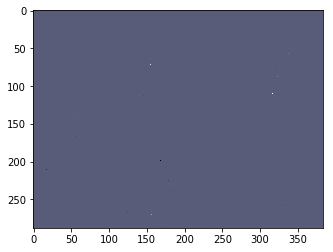

In [91]:
plt.imshow(1/(x+1e-1),cmap='bone')

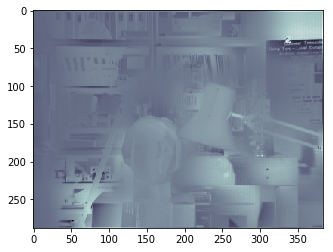

In [95]:
plt.imshow(Edd.cpu().data.numpy(),cmap='bone')
plt.imshow((Ed).cpu().data.numpy(),cmap='bone')

(array([2.00000e+00, 1.00000e+00, 2.00000e+00, 1.30000e+01, 1.33000e+02,
        5.74000e+02, 7.50100e+03, 1.01305e+05, 9.97000e+02, 6.40000e+01]),
 array([-1450.90551758, -1247.67745361, -1044.44938965,  -841.22132568,
         -637.99326172,  -434.76519775,  -231.53713379,   -28.30906982,
          174.91899414,   378.14705811,   581.37512207]),
 <a list of 10 Patch objects>)

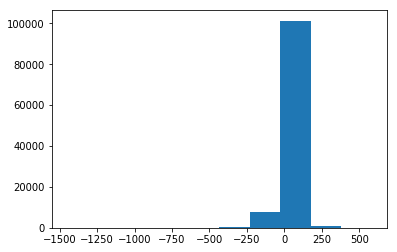

In [76]:
plt.hist(x.reshape(-1))

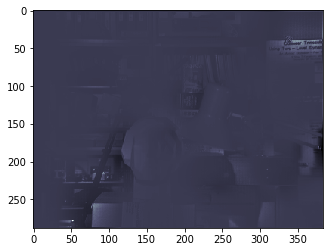

In [107]:
plt.imshow(np.exp(-.0001*(Edd-Ed*Ed).cpu().data.numpy()),cmap='bone')